# Import Functions

In [1]:
import pencilbox as pb
import pandas as pd
import numpy as np
import time
import os
from datetime import date, datetime, timedelta
import json
import shutil 
!pip install pymysql
import pymysql

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
#from pyemma import msm
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

import boto3
import io

!pip install matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.ensemble import IsolationForest


import requests
from requests.exceptions import HTTPError

!pip install pandasql
import pandasql as ps

from tqdm.notebook import tqdm
CON_REDSHIFT = pb.get_connection("[Warehouse] Redshift")
CON_TRINO = pb.get_connection("[Warehouse] Trino")

In [2]:
def read_sql_query(sql, con):
    max_tries = 3
    for attempt in range(max_tries):
        print(f"Read attempt: {attempt}...")
        try:
            start = time.time()
            df = pd.read_sql_query(sql, con)
            end = time.time()
            if (end - start) > 60:
                print("Time: ", (end - start) / 60, "min")
            else:
                print("Time: ", end - start, "s")
            return df
            break
        except BaseException as e:
            print(e)
            time.sleep(5)

In [3]:
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 300)
import warnings
warnings.filterwarnings('ignore')

In [4]:
outliers_fraction = 0.01
final_df = pd.DataFrame()

# Fetch Sales

In [234]:
order_query = f"""
with
item_details as
    (select item_id, 
        (id.name || ' ' || id.variant_description) as item_name
            from lake_rpc.item_details id
    ),

item_mapping as
    (select distinct ipr.product_id,
        case when ipr.item_id is null then ipom_0.item_id else ipr.item_id end as item_id,
        case when ipr.item_id is not null then COALESCE(ipom.multiplier,1) else COALESCE(ipom_0.multiplier,1) end as multiplier
            
            from lake_rpc.item_product_mapping ipr

                left join
                    dwh.dim_item_product_offer_mapping ipom on ipom.product_id = ipr.product_id
                        and ipr.item_id = ipom.item_id
                left join
                    dwh.dim_item_product_offer_mapping ipom_0 on ipom_0.product_id = ipr.product_id
    ),

sales as
    (select 
        (oid.cart_checkout_ts_ist) as order_date,
        cl.name as city_name,
        rco.facility_id,
        pt.name as p_type,
        oid.product_id,
        im.item_id,
        oid.cart_id,
        oid.dim_customer_key,
        ((unit_selling_price * 1.00)/im.multiplier) as item_selling_price,
        ((unit_mrp * 1.00)/im.multiplier) as item_selling_mrp,
        im.multiplier,
        oid.total_doorstep_return_quantity,
        ((oid.procured_quantity - oid.total_doorstep_return_quantity) * im.multiplier) as sales_quantity,
        (sales_quantity * item_selling_price) as sales_value,
        (sales_quantity * item_selling_mrp) as sales_value_mrp
        
            from dwh.fact_sales_order_item_details oid
            
                join item_mapping im on im.product_id = oid.product_id
                
                join lake_retail.console_outlet rco on rco.id = oid.outlet_id and business_type_id in (7)
                join lake_retail.console_location cl on cl.id = rco.tax_location_id
                left join 
        (select item_id, product_id from lake_rpc.item_product_mapping) ipm on ipm.product_id = oid.product_id
    left join 
        (select id, type_id from lake_cms.gr_product) gp on gp.id = ipm.product_id
    left join 
        (select id, name from lake_cms.gr_product_type) pt on pt.id = gp.type_id
                
                    where (oid.cart_checkout_ts_ist between (current_date - 90 || ' 00:00:00')::timestamp and (current_date || ' 23:59:59')::timestamp)
                        and oid.is_internal_order = false
                        and (oid.order_type not ilike '%%internal%%' or oid.order_type is null)
                        and oid.procured_quantity > 0
                        and oid.order_current_status = 'DELIVERED'
    ),

discard_carts as 
    (
        SELECT
            DISTINCT city_name,
            item_id,
            1 as remove_flag
        FROM
        (SELECT
            EXTRACT(MONTH FROM oid.cart_checkout_ts_ist) AS month,
            cl.name as city_name,
            im.item_id,
            COUNT(DISTINCT oid.cart_id) as total_carts
        FROM
            dwh.fact_sales_order_item_details oid
        JOIN
            item_mapping im ON im.product_id = oid.product_id
        JOIN lake_retail.console_outlet rco ON rco.id = oid.outlet_id and business_type_id in (7)
        JOIN lake_retail.console_location cl ON cl.id = rco.tax_location_id
        WHERE
            (oid.cart_checkout_ts_ist between (current_date - 90 || ' 00:00:00')::timestamp and (current_date || ' 23:59:59')::timestamp)
            AND oid.is_internal_order = false
            AND (oid.order_type not ilike '%%internal%%' or oid.order_type is null)
            AND oid.procured_quantity > 0 
            AND oid.order_current_status = 'DELIVERED'
        GROUP BY 1,2,3)
        WHERE total_carts < 3
),

cart_data AS
  (
    SELECT 
        DISTINCT cart_id,
        sum(sales_quantity) AS order_quantity
    FROM 
        sales
    GROUP BY 1
),

final_sales as
    (select 
        date(order_date) as date_,
        city_name,
        p_type,
        s.item_id,
        item_name, 
        sum(sales_quantity)::int as sales_quantity,
        sum(sales_value) as sales_value,
        sum(sales_value_mrp) as sales_value_mrp,
        avg(cast(sales_quantity AS float)/cast(order_quantity AS float)) AS ipc
        
            from sales s
            
                join
                    item_details id on id.item_id = s.item_id
                JOIN
        cart_data c ON s.cart_id = c.cart_id
                    
                    where sales_quantity > 0
                    
                        group by 1,2,3,4,5
    )
    
        SELECT fs.*, dc.remove_flag
        FROM final_sales fs 
        LEFT JOIN discard_carts dc ON fs.city_name = dc.city_name AND fs.item_id = dc.item_id
        WHERE fs.item_id IN (10000953) -- (10000953, 10043867, 10002530, 10000628, 10001013)
            """

order_data = read_sql_query(order_query, CON_REDSHIFT)
order_data['date_'] = pd.to_datetime(order_data['date_'])
order_data.head()

Read attempt: 0...
Time:  38.131739139556885 s


,date_,city_name,p_type,item_id,item_name,sales_quantity,sales_value,sales_value_mrp,ipc,remove_flag
0,2023-04-27,Hyderabad,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,13,330.0,351.0,0.270193,NaN
1,2023-04-28,Bengaluru,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,35,892.0,945.0,0.231916,NaN
2,2023-05-05,Ghaziabad,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,110,2805.0,2970.0,0.248471,NaN
3,2023-05-26,Bengaluru,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,84,2142.0,2268.0,0.332152,NaN
4,2023-05-30,Faridabad,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,26,668.0,702.0,0.300814,NaN


In [235]:
# order_data = order_data[order_data['remove_flag'] != 1]
order_data = order_data.drop(columns=['remove_flag'])
order_data.head()

,date_,city_name,p_type,item_id,item_name,sales_quantity,sales_value,sales_value_mrp,ipc
0,2023-04-27,Hyderabad,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,13,330.0,351.0,0.270193
1,2023-04-28,Bengaluru,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,35,892.0,945.0,0.231916
2,2023-05-05,Ghaziabad,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,110,2805.0,2970.0,0.248471
3,2023-05-26,Bengaluru,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,84,2142.0,2268.0,0.332152
4,2023-05-30,Faridabad,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,26,668.0,702.0,0.300814


In [236]:
#order_df = pd.read_csv('sample-orders-data.csv')
order_df = order_data.copy()
order_df['Sales'] = order_df['sales_quantity']
order_df['Sales'].describe()

# order_df.head(2)

count    1595.000000
mean       99.461442
std       283.695171
min         1.000000
25%         6.000000
50%        18.000000
75%        72.000000
max      3974.000000
Name: Sales, dtype: float64

In [237]:
order_df.head()

,date_,city_name,p_type,item_id,item_name,sales_quantity,sales_value,sales_value_mrp,ipc,Sales
0,2023-04-27,Hyderabad,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,13,330.0,351.0,0.270193,13
1,2023-04-28,Bengaluru,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,35,892.0,945.0,0.231916,35
2,2023-05-05,Ghaziabad,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,110,2805.0,2970.0,0.248471,110
3,2023-05-26,Bengaluru,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,84,2142.0,2268.0,0.332152,84
4,2023-05-30,Faridabad,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,26,668.0,702.0,0.300814,26


In [238]:
item_ptype_mapping = order_data[['p_type','item_id','item_name']].drop_duplicates()
item_ptype_mapping.head()

,p_type,item_id,item_name
0,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27


# EDA

In [239]:
order_df.isna().sum()

date_              0
city_name          0
p_type             0
item_id            0
item_name          0
sales_quantity     0
sales_value        0
sales_value_mrp    0
ipc                0
Sales              0
dtype: int64

In [240]:
order_df = order_df.dropna()

In [241]:
order_df['date_'] = pd.to_datetime(order_df['date_'])

In [242]:
order_df['date_'].min()

Timestamp('2023-04-22 00:00:00')

In [243]:
order_df['date_'].max()

Timestamp('2023-07-21 00:00:00')

In [244]:
order_df = order_df.sort_values(by='date_').reset_index(drop = True)

In [245]:
order_df.head()

,date_,city_name,p_type,item_id,item_name,sales_quantity,sales_value,sales_value_mrp,ipc,Sales
0,2023-04-22,Amritsar,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,1,26.0,27.0,0.142857,1
1,2023-04-22,Bengaluru,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,86,2228.0,2322.0,0.227775,86
2,2023-04-22,Zirakpur,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,2,52.0,54.0,0.067194,2
3,2023-04-22,Mumbai,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,21,544.0,567.0,0.283011,21
4,2023-04-22,Delhi,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,365,9442.0,9855.0,0.262571,365


In [246]:
x_train = order_df.copy()

## Visualisation

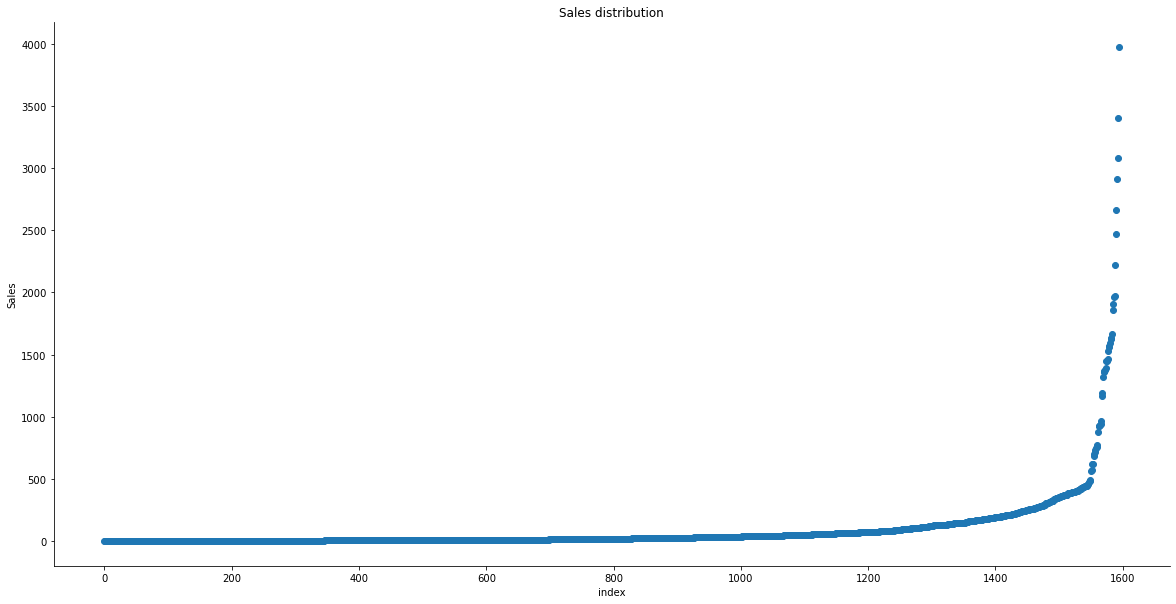

In [247]:
plt.subplots(figsize=(20,10))
plt.scatter(range(x_train.shape[0]), np.sort(x_train['Sales'].values))
plt.xlabel('index')
plt.ylabel('Sales')
plt.title("Sales distribution")
sns.despine()

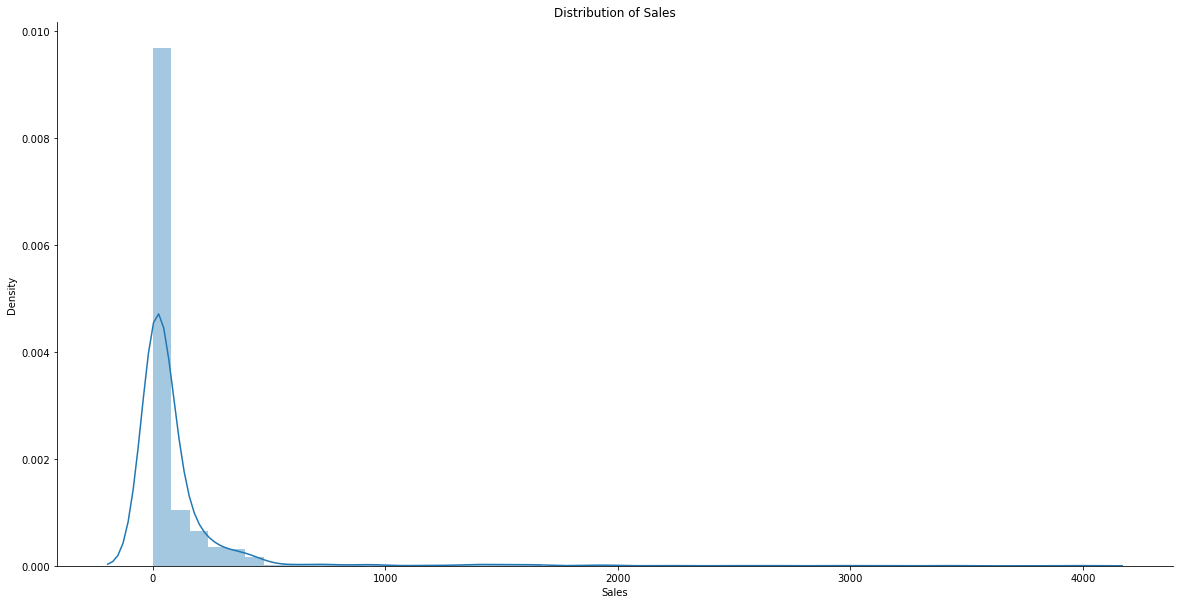

In [248]:
plt.subplots(figsize=(20,10))
sns.distplot(x_train['Sales'])
plt.title("Distribution of Sales")
sns.despine()

In [249]:
x_train['Sales'].skew()

7.085235710586689

# Feature Engineering

In [250]:
x_train = order_df.copy()
#item_id = 10000490
#box_x_train = x_train[x_train['item_id'] == item_id].reset_index().drop(columns = {'index'})
box_x_train = x_train.copy()

In [251]:
# from sklearn.preprocessing import PowerTransformer

# fit = PowerTransformer(
#    method = 'box-cox'
# )

# box_x_train['Sales'] = fit.fit_transform(
#    np.array(box_x_train['sales_quantity']).reshape(-1, 1)
# )

In [252]:
from scipy import stats
box_x_train['Sales'] = stats.boxcox(box_x_train['sales_quantity'])[0]

# plt.subplots(figsize=(20,10))
# plt.scatter(range(box_x_train.shape[0]), np.sort(box_x_train['Sales'].values))
# plt.xlabel('index')
# plt.ylabel('Sales')
# plt.title("Sales distribution")
# sns.despine()

In [253]:
box_x_train.head()

,date_,city_name,p_type,item_id,item_name,sales_quantity,sales_value,sales_value_mrp,ipc,Sales
0,2023-04-22,Amritsar,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,1,26.0,27.0,0.142857,0.000000
1,2023-04-22,Bengaluru,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,86,2228.0,2322.0,0.227775,3.757435
2,2023-04-22,Zirakpur,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,2,52.0,54.0,0.067194,0.674583
3,2023-04-22,Mumbai,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,21,544.0,567.0,0.283011,2.707286
4,2023-04-22,Delhi,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,365,9442.0,9855.0,0.262571,4.719799


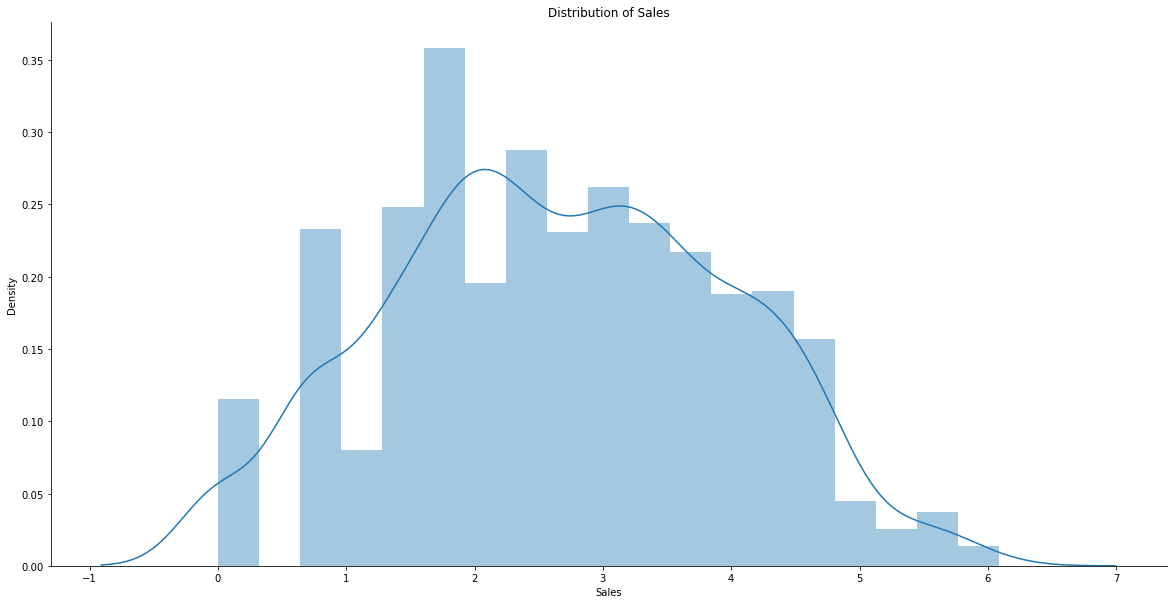

In [254]:
plt.subplots(figsize=(20,10))
sns.distplot(box_x_train['Sales'])
plt.title("Distribution of Sales")
sns.despine()

In [255]:
# plt.subplots(figsize=(20,10))
# sns.distplot(box_x_train['Sales_new'])
# plt.title("Distribution of Sales")
# sns.despine()

In [256]:
box_x_train['Sales'].skew()

0.02943942643193045

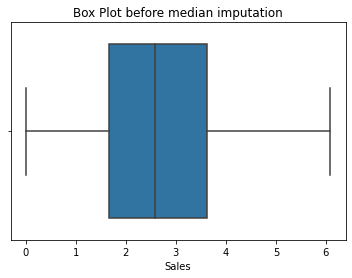

In [257]:
#median imputation

sns.boxplot(box_x_train['Sales'])
plt.title("Box Plot before median imputation")
plt.show()
# q1 = box_x_train['Sales'].quantile(0.25)
# q3 = box_x_train['Sales'].quantile(0.75)
# iqr = q3-q1
# Lower_tail = q1 - 1.5 * iqr
# Upper_tail = q3 + 1.5 * iqr
# med = np.median(box_x_train['Sales'])
# for i in box_x_train['Sales']:
#     if i > Upper_tail or i < Lower_tail:
#             box_x_train['Sales'] = box_x_train['Sales'].replace(i, med)
# sns.boxplot(box_x_train['Sales'])
# plt.title("Box Plot after median imputation")
# plt.show()

# Model

In [258]:
box_x_train['date_'].dt.day

0       22
1       22
2       22
3       22
4       22
        ..
1590    21
1591    21
1592    21
1593    21
1594    21
Name: date_, Length: 1595, dtype: int64

In [259]:
box_x_train['hours'] = box_x_train['date_'].dt.hour
box_x_train['week'] = box_x_train['date_'].dt.week
box_x_train['day'] = box_x_train['date_'].dt.day
box_x_train['month'] = box_x_train['date_'].dt.month
box_x_train['DayOfTheWeek'] = box_x_train['date_'].dt.dayofweek
box_x_train['WeekDay'] = (box_x_train['DayOfTheWeek'] < 5).astype(int)

In [260]:
box_x_train.head()

,date_,city_name,p_type,item_id,item_name,sales_quantity,sales_value,sales_value_mrp,ipc,Sales,hours,week,day,month,DayOfTheWeek,WeekDay
0,2023-04-22,Amritsar,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,1,26.0,27.0,0.142857,0.000000,0,16,22,4,5,0
1,2023-04-22,Bengaluru,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,86,2228.0,2322.0,0.227775,3.757435,0,16,22,4,5,0
2,2023-04-22,Zirakpur,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,2,52.0,54.0,0.067194,0.674583,0,16,22,4,5,0
3,2023-04-22,Mumbai,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,21,544.0,567.0,0.283011,2.707286,0,16,22,4,5,0
4,2023-04-22,Delhi,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,365,9442.0,9855.0,0.262571,4.719799,0,16,22,4,5,0


In [261]:
# Take useful feature and standardize them
# data = box_x_train[['Sales', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
data = box_x_train[['Sales', 'hours', 'WeekDay']]
# min_max_scaler = preprocessing.StandardScaler()
# np_scaled = min_max_scaler.fit_transform(data)
# data = pd.DataFrame(np_scaled)
# n_cluster = range(1, 6)
kmeans = KMeans(n_clusters=3, init='k-means++',n_init=20, random_state=42, algorithm='auto', max_iter=100).fit(data)
scores = kmeans.score(data)

# kmeans = [KMeans(n_clusters=i, init='k-means++',n_init=20, random_state=42, algorithm='auto', max_iter=500).fit(data) for i in n_cluster]
# scores = [kmeans[i].score(data) for i in range(len(kmeans))]
# fig, ax = plt.subplots(figsize=(20,10))
# ax.plot(n_cluster, scores)
# plt.show()

In [262]:
# Not clear for me, I choose 15 centroids arbitrarily and add these data to the central dataframe
box_x_train['cluster'] = kmeans.predict(data)
#box_x_train['cluster'] = kmeans[2].predict(data)
box_x_train['cluster'].value_counts()

0    673
1    506
2    416
Name: cluster, dtype: int64

In [263]:
# from sklearn import metrics
# metrics.silhouette_score(data, kmeans.labels_,metric='euclidean')
# #metrics.silhouette_score(data, kmeans[2].labels_,metric='euclidean')

In [264]:
pair = {}
pair_list = []
pair[0] = box_x_train[box_x_train['cluster'] == 0]['Sales'].mean()
pair_list.append(box_x_train[box_x_train['cluster'] == 0]['Sales'].mean())
pair[1] = box_x_train[box_x_train['cluster'] == 1]['Sales'].mean()
pair_list.append(box_x_train[box_x_train['cluster'] == 1]['Sales'].mean())
pair[2] = box_x_train[box_x_train['cluster'] == 2]['Sales'].mean()
pair_list.append(box_x_train[box_x_train['cluster'] == 2]['Sales'].mean())

In [265]:
minimum = min(pair.values())
pair_list.remove(minimum)
minimum = [key for key, value in pair.items() if value == minimum][0]
maximum = max(pair.values())
pair_list.remove(maximum)
maximum = [key for key, value in pair.items() if value == maximum][0]
no_outleir_key = pair_list[0]
no_outleir_key = [key for key, value in pair.items() if value == no_outleir_key][0]

minimum, maximum, no_outleir_key

(2, 1, 0)

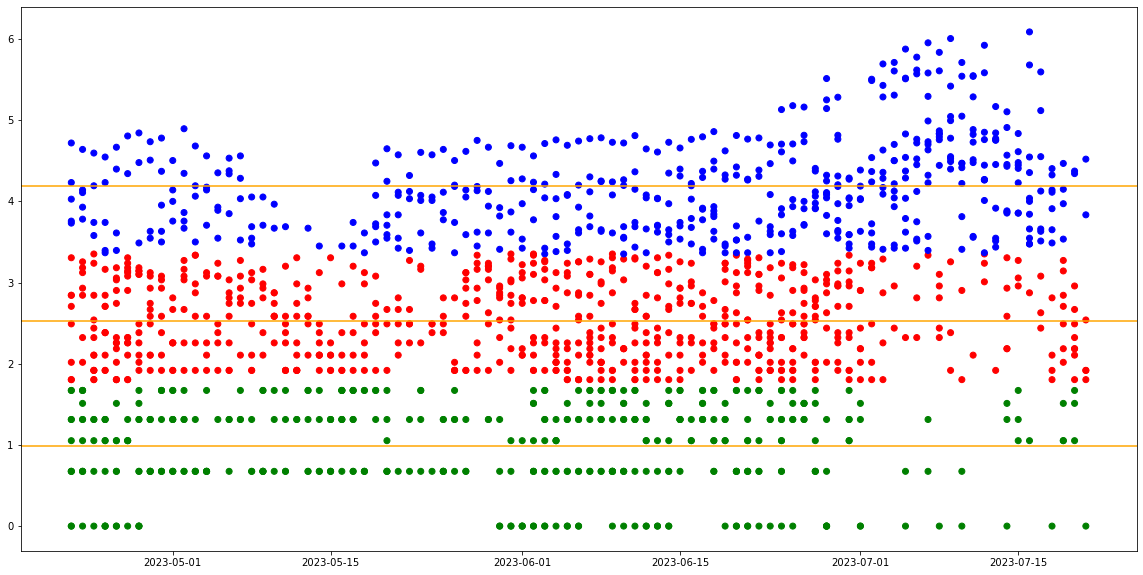

In [266]:
#plot the different clusters with the 2 main features
fig, ax = plt.subplots(figsize=(20,10))
colors = {0:'red', 1:'blue', 2:'green', 3:'black'}
ax.scatter(box_x_train['date_'], box_x_train['Sales'], c=box_x_train["cluster"].apply(lambda x: colors[x]))
ax.axhline(y = box_x_train[box_x_train['cluster'] == minimum]['Sales'].mean(), color='orange')
ax.axhline(y = box_x_train[box_x_train['cluster'] == no_outleir_key]['Sales'].mean(), color='orange')
ax.axhline(y = box_x_train[box_x_train['cluster'] == maximum]['Sales'].mean(), color='orange')
plt.show()

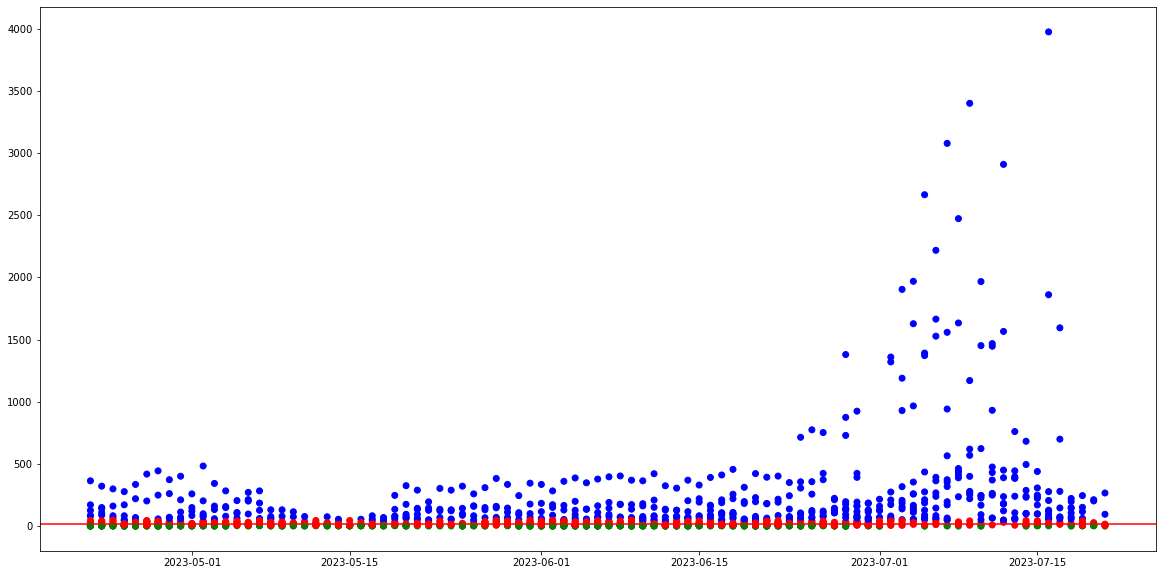

In [267]:
min_val = box_x_train[box_x_train['cluster'] == minimum]['sales_quantity'].mean()
max_val = box_x_train[box_x_train['cluster'] == maximum]['sales_quantity'].mean()
fval = box_x_train[box_x_train['cluster'] == no_outleir_key]['sales_quantity'].mean()
min_fval, max_fval = fval, fval

fig, ax = plt.subplots(figsize=(20,10))
colors = {0:'red', 1:'blue', 2:'green', 3:'black'}
ax.scatter(box_x_train['date_'], box_x_train['sales_quantity'], c=box_x_train["cluster"].apply(lambda x: colors[x]))
ax.axhline(y = fval, color='r')
plt.show()

In [268]:
min_val, max_val

(3.3052884615384617, 283.7905138339921)

3.3052884615384617 283.7905138339921


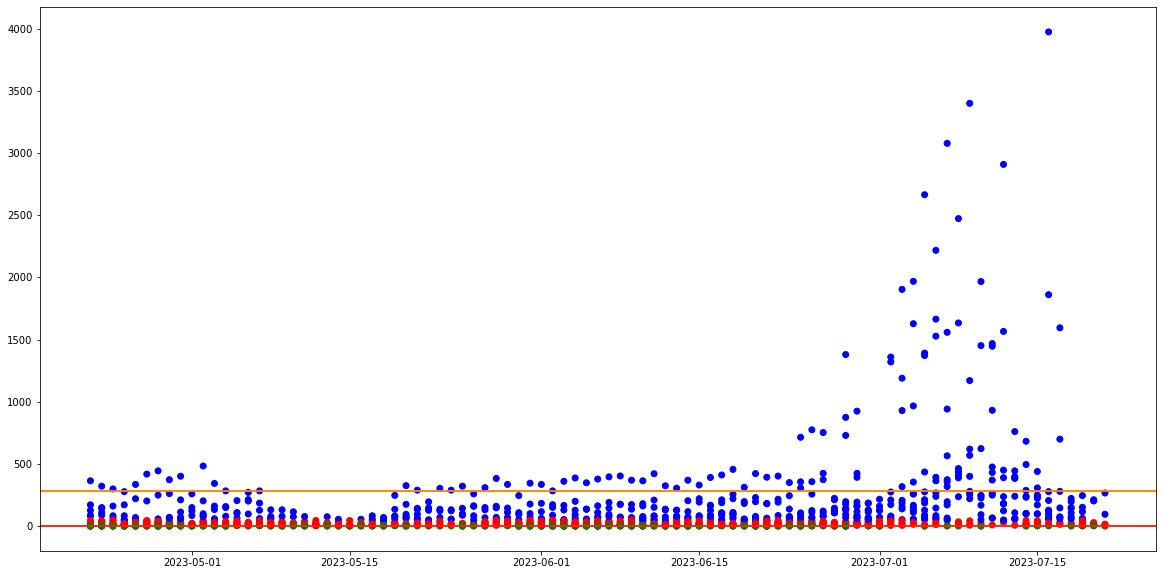

In [269]:
# min_fval = (min_val + min_fval)/2
# max_fval = (max_val + max_fval)/2
# print(min_fval, max_fval)
min_fval = min_val
max_fval = max_val
print(min_fval, max_fval)
fig, ax = plt.subplots(figsize=(20,10))
colors = {0:'red', 1:'blue', 2:'green', 3:'black'}
ax.scatter(box_x_train['date_'], box_x_train['sales_quantity'], c=box_x_train["cluster"].apply(lambda x: colors[x]))
ax.axhline(y = box_x_train[box_x_train['cluster'] == minimum]['sales_quantity'].mean(), color='orange')
ax.axhline(y = min_fval, color='r')
ax.axhline(y = max_fval, color='r')
ax.axhline(y = box_x_train[box_x_train['cluster'] == maximum]['sales_quantity'].mean(), color='orange')
plt.show()

In [270]:
box_x_train.head()

,date_,city_name,p_type,item_id,item_name,sales_quantity,sales_value,sales_value_mrp,ipc,Sales,hours,week,day,month,DayOfTheWeek,WeekDay,cluster
0,2023-04-22,Amritsar,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,1,26.0,27.0,0.142857,0.000000,0,16,22,4,5,0,2
1,2023-04-22,Bengaluru,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,86,2228.0,2322.0,0.227775,3.757435,0,16,22,4,5,0,1
2,2023-04-22,Zirakpur,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,2,52.0,54.0,0.067194,0.674583,0,16,22,4,5,0,2
3,2023-04-22,Mumbai,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,21,544.0,567.0,0.283011,2.707286,0,16,22,4,5,0,0
4,2023-04-22,Delhi,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,365,9442.0,9855.0,0.262571,4.719799,0,16,22,4,5,0,1


In [271]:
box_x_train['city_outlier_flag'] = np.where(box_x_train['cluster'].isin([minimum, maximum]), 1, 0)

In [272]:
box_x_train.head()

,date_,city_name,p_type,item_id,item_name,sales_quantity,sales_value,sales_value_mrp,ipc,Sales,hours,week,day,month,DayOfTheWeek,WeekDay,cluster,city_outlier_flag
0,2023-04-22,Amritsar,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,1,26.0,27.0,0.142857,0.000000,0,16,22,4,5,0,2,1
1,2023-04-22,Bengaluru,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,86,2228.0,2322.0,0.227775,3.757435,0,16,22,4,5,0,1,1
2,2023-04-22,Zirakpur,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,2,52.0,54.0,0.067194,0.674583,0,16,22,4,5,0,2,1
3,2023-04-22,Mumbai,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,21,544.0,567.0,0.283011,2.707286,0,16,22,4,5,0,0,0
4,2023-04-22,Delhi,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,365,9442.0,9855.0,0.262571,4.719799,0,16,22,4,5,0,1,1


In [273]:
box_x_train.to_csv('city_outlier_flag.csv', index = False)

# ------END---------

## Seasonality

- include search data
- weightage to sales 30% and search 70%

In [274]:
query = f"""
SELECT item_id, l2_id, l2 FROM lake_rpc.item_category_details
"""
item_l2_df = read_sql_query(query, CON_REDSHIFT)
item_l2_df = item_l2_df[['item_id','l2_id']].rename(columns={'l2_id':'l2_category_id'})
item_l2_df.head()

Read attempt: 0...
Time:  2.3164589405059814 s


,item_id,l2_category_id
0,10083481,2
1,10085035,6
2,10085042,6
3,10085047,6
4,10016462,8


In [279]:
query = f"""
DROP TABLE IF EXISTS keyword_pid;
    CREATE temporary table keyword_pid as (
    select
        trim(lower(properties__search_actual_keyword))::varchar as keyword,
        properties__product_id as product_id,
        dmm.facility_id,
        l2_category_id,
        at_date_ist as date_,
        count (device_uuid) as key_prod_atc
    from 
        spectrum.mobile_event_data k
        inner join dwh.dim_product p 
            on k.properties__product_id = p.product_id 
            and is_current = true 
            and is_product_enabled = true
        join dwh.dim_merchant_outlet_facility_mapping dmm 
            on dmm.frontend_merchant_id = traits__merchant_id
            and is_express_store = True
            and dmm.is_current = True
    where 
        at_date_ist between '2023-07-09' and '2023-07-13'
        and name = 'Product Added'
        and properties__search_actual_keyword is not null
        and properties__search_actual_keyword not in ('-NA-', '#-NA', '')
        and properties__search_keyword_parent in ('type-to-search', 'type_to_search')
        and traits__user_id is not NULL
        and traits__user_id not in (-1,0)
        and traits__user_id not in ('14647274', '9961423','9709403','13957980','13605597','3927621','14740725','4144617','10045662')
        and traits__city_id is not NULL
        and traits__merchant_id is not NULL
        and traits__merchant_name is not NULL
        and keyword not in ('',' ','#-na')
        and len(keyword)>2
    group by 1,2,3,4,5
    );
    
    DROP TABLE IF EXISTS search;
    CREATE TEMPORARY TABLE search as(
    select 
        at_date_ist as date_,
        dmm.facility_id,
        traits__merchant_id,
        lower(device_uuid) device_uuid,
        trim(lower(properties__search_actual_keyword))::varchar as keyword
    from 
        spectrum.mobile_event_data
    join dwh.dim_merchant_outlet_facility_mapping dmm 
        on dmm.frontend_merchant_id = traits__merchant_id
        and is_express_store = True
        and dmm.is_current = True
    where
        at_date_ist between '2023-07-09' and '2023-07-13'
        and name = 'Product Searched'
        and properties__search_actual_keyword is not null
        and properties__search_actual_keyword not in ('-NA-', '#-NA', '')
        and properties__search_keyword_parent in ('type-to-search', 'type_to_search')
        and traits__user_id is not NULL
        and traits__user_id not in (-1,0)
        and traits__user_id not in ('14647274', '9961423','9709403','13957980','13605597','3927621','14740725','4144617','10045662')
        and traits__city_id is not NULL
        and traits__merchant_id is not NULL
        and traits__merchant_name is not NULL
        and keyword not in ('',' ','#-na')
        and len(keyword)>2

    group by 1,2,3,4,5

    );

    with keyword_atc as (
    select 
        keyword keyword1,
        sum(key_prod_atc) as key_tot_atc
    from keyword_pid
    group by 1
    having key_tot_atc >= 100
    ),

    l0_atc as (
    select
        l2_category_id,
        sum(key_prod_atc) as l0_tot_atc
    from 
        keyword_pid k
    group by 1
    ),

    keyword_l0 as(
    select 
        k.keyword,
        key_tot_atc,
        k.l2_category_id,
        l0_tot_atc,
        sum(key_prod_atc) as key_l0_atc,
        (key_l0_atc*100/key_tot_atc) as l0_in_key,
        (key_l0_atc*100.00/l0_tot_atc) as key_in_l0,
        row_number () over (partition by k.l2_category_id order by key_l0_atc desc) as keyword_rank_in_l0
    from 
        keyword_pid k 
        inner join keyword_atc a on k.keyword = a.keyword1
        inner join l0_atc l on l.l2_category_id=k.l2_category_id
    group by 1,2,3,4
    having key_l0_atc > 10 
    )
    ,

    pre_final as (
    select
        l2_category_id,
        keyword
    from 
        keyword_l0
    where 
        key_in_l0>=0.1
        and l0_in_key >=10
    group by 1,2
    order by l2_category_id
    )

    select 
        s.date_,
        cl.name as city_name,
        l2_category_id,
        s.traits__merchant_id as merchant_id,
        count (s.device_uuid) as searches
    from 
        search s
    join 
        pre_final u on u.keyword = s.keyword
    INNER JOIN
        lake_retail.console_outlet co ON co.facility_id = s.facility_id
    INNER JOIN
        lake_retail.console_location cl ON co.tax_location_id = cl.id
    group by 1,2,3,4
"""
search_l2_df = read_sql_query(query, CON_REDSHIFT)
search_l2_df.head()

Read attempt: 0...
Time:  49.372633934020996 s


,date_,city_name,l2_category_id,merchant_id,searches
0,2023-07-11,Delhi,1173,32038,30
1,2023-07-11,Delhi,113,31264,10
2,2023-07-12,Bengaluru,1172,30788,36
3,2023-07-12,Ghaziabad,1489,32750,72
4,2023-07-10,Delhi,54,31372,22


In [280]:
search_l2_df = search_l2_df[search_l2_df['l2_category_id'] == 932]

In [281]:
search_l2_df = search_l2_df.merge(item_l2_df, on=['l2_category_id'], how = 'left')
search_l2_df = search_l2_df.groupby(['city_name','item_id']).agg({'searches':'mean'}).reset_index()
search_l2_df.head()

,city_name,item_id,searches
0,Ahmedabad,10000029,12.057971
1,Ahmedabad,10000038,12.057971
2,Ahmedabad,10000039,12.057971
3,Ahmedabad,10000158,12.057971
4,Ahmedabad,10000159,12.057971


In [284]:
box_x_train = box_x_train.merge(search_l2_df, on=['city_name','item_id'], how = 'inner')
box_x_train.head()

,date_,city_name,p_type,item_id,item_name,sales_quantity,sales_value,sales_value_mrp,ipc,Sales,hours,week,day,month,DayOfTheWeek,WeekDay,cluster,city_outlier_flag,searches
0,2023-04-22,Amritsar,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,1,26.0,27.0,0.142857,0.000000,0,16,22,4,5,0,2,1,18.8
1,2023-04-23,Amritsar,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,2,52.0,54.0,0.208333,0.674583,0,16,23,4,6,0,2,1,18.8
2,2023-04-25,Amritsar,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,4,104.0,108.0,0.319192,1.313356,0,17,25,4,1,1,2,1,18.8
3,2023-04-26,Amritsar,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,3,78.0,81.0,0.133929,1.052464,0,17,26,4,2,1,2,1,18.8
4,2023-04-27,Amritsar,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,1,26.0,27.0,0.200000,0.000000,0,17,27,4,3,1,2,1,18.8


In [285]:
box_x_train['seasonality_calc'] = ((0.3 * box_x_train['sales_quantity']) + (0.7 * box_x_train['searches']))
box_x_train.head()

,date_,city_name,p_type,item_id,item_name,sales_quantity,sales_value,sales_value_mrp,ipc,Sales,hours,week,day,month,DayOfTheWeek,WeekDay,cluster,city_outlier_flag,searches,seasonality_calc
0,2023-04-22,Amritsar,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,1,26.0,27.0,0.142857,0.000000,0,16,22,4,5,0,2,1,18.8,13.46
1,2023-04-23,Amritsar,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,2,52.0,54.0,0.208333,0.674583,0,16,23,4,6,0,2,1,18.8,13.76
2,2023-04-25,Amritsar,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,4,104.0,108.0,0.319192,1.313356,0,17,25,4,1,1,2,1,18.8,14.36
3,2023-04-26,Amritsar,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,3,78.0,81.0,0.133929,1.052464,0,17,26,4,2,1,2,1,18.8,14.06
4,2023-04-27,Amritsar,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,1,26.0,27.0,0.200000,0.000000,0,17,27,4,3,1,2,1,18.8,13.46


In [288]:
box_x_train['city_seasonality_flag'] = np.where(box_x_train['searches'] > box_x_train['seasonality_calc'], 1, 0)
box_x_train.head()

,date_,city_name,p_type,item_id,item_name,sales_quantity,sales_value,sales_value_mrp,ipc,Sales,hours,week,day,month,DayOfTheWeek,WeekDay,cluster,city_outlier_flag,searches,seasonality_calc,city_seasonality_flag
0,2023-04-22,Amritsar,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,1,26.0,27.0,0.142857,0.000000,0,16,22,4,5,0,2,1,18.8,13.46,1
1,2023-04-23,Amritsar,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,2,52.0,54.0,0.208333,0.674583,0,16,23,4,6,0,2,1,18.8,13.76,1
2,2023-04-25,Amritsar,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,4,104.0,108.0,0.319192,1.313356,0,17,25,4,1,1,2,1,18.8,14.36,1
3,2023-04-26,Amritsar,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,3,78.0,81.0,0.133929,1.052464,0,17,26,4,2,1,2,1,18.8,14.06,1
4,2023-04-27,Amritsar,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,1,26.0,27.0,0.200000,0.000000,0,17,27,4,3,1,2,1,18.8,13.46,1


In [289]:
box_x_train.to_csv('city_outlier_flag.csv', index = False)